In [154]:
# import libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt 
from scipy.fftpack import fft,ifft
import soundfile as sf
from scipy.io import wavfile
from scipy.signal.windows import hamming, hann, blackman

In [144]:
def create_sin_waves(frequency, amplitude, duration, sampling_rate, phase):
  t = np.linspace(0, duration, int(sampling_rate * duration))
  y = amplitude * np.sin(2 * np.pi * frequency * t + phase)
  return y, t

In [146]:
def power_spectrum_fn(x_audio, fs_audio, hop_size, window, win_size, nfft):
    nframes = int((len(x_audio) - win_size) / hop_size) + 1
    
    # Prepare matrix for storing spectra
    power_spectrogram = np.zeros((nfft // 2, nframes))
    
    # Loop through the frames
    for i in range(nframes):
        start = i * hop_size
        segment = x_audio[start:start + win_size]
        
        # Multiply each frame with window
        segment_wind = segment * window
        
        # Compute FFT
        spectrum = fft(segment_wind, nfft)
        
        # Power spectrum (only positive frequencies)
        power_spectrum = np.abs(spectrum[:nfft // 2]) ** 2
        
        # Store into matrix
        power_spectrogram[:, i] = power_spectrum
    
    # Return full spectrogram
    return power_spectrogram, nframes


In [147]:
def plot_spectrogram(power_spectrogram_, fs_audio_, hop_size, title_):
    nframes = power_spectrogram_.shape[1]
    plt.figure(figsize=(6, 4))
    plt.imshow(
        10*np.log10(power_spectrogram_ + 1e-12),
        origin='lower',
        aspect='auto',
        extent=[0, nframes * hop_size / fs_audio_, 0, fs_audio_ / 2]
    )
    plt.title(title_)
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.colorbar(label='Power (dB)')
    plt.show()


In [181]:
def compare_windowing(x_audio, fs_audio, win_size, nfft, start_index=None):
    """Compare DFT with and without windowing"""
    hop_size = win_size // 2  # 50% overlap
    
    # If no start_index provided, use second frame
    if start_index is None:
        start_index = hop_size  # Start from second frame
    
    # Make sure we don't go beyond signal length
    if start_index + win_size > len(x_audio):
        start_index = len(x_audio) - win_size  # Adjust to fit
    
    frame = x_audio[start_index:start_index + win_size]
    
    # Without windowing (rectangular window)
    spectrum_no_window = np.abs(fft(frame, nfft)[:nfft//2]) ** 2
    
    # With Hamming window
    hamming_window = hamming(win_size)
    frame_windowed = frame * hamming_window
    spectrum_windowed = np.abs(fft(frame_windowed, nfft)[:nfft//2]) ** 2
    
    # Plot comparison
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(spectrum_no_window)
    plt.title('Power Spectrum - No Windowing (Rectangular)')
    plt.xlabel('Frequency Bin')
    plt.ylabel('Power')
    
    plt.subplot(1, 2, 2)
    plt.plot(spectrum_windowed)
    plt.title('Power Spectrum - Hamming Window')
    plt.xlabel('Frequency Bin')
    plt.ylabel('Power')
    
    plt.tight_layout()
    plt.show()
    
    return spectrum_no_window, spectrum_windowed

In [173]:
def test_windows_on_audio(x_audio, fs_audio, signal_name, window_types, win_ms_list):
    for win_name in window_types:
        # Create one figure for all window sizes of this window type
        fig, axes = plt.subplots(1, len(win_ms_list), figsize=(20, 4))
        
        if len(win_ms_list) == 1:
            axes = [axes]  # Make it iterable if only one subplot
        
        for i, win_ms in enumerate(win_ms_list):
            win_size = int(win_ms * 1e-3 * fs_audio)
            hop_size = int(win_size * 0.5)
            nfft = win_size

            # Create window
            if win_name == 'hann':
                window = hann(win_size)
            elif win_name == 'hamming':
                window = hamming(win_size)
            elif win_name == 'blackman':
                window = blackman(win_size)

            # Compute spectrogram
            power_spectrogram, nframes = power_spectrum_fn(
                x_audio, fs_audio, hop_size, window, win_size, nfft
            )

            # Plot on subplot
            im = axes[i].imshow(
                10*np.log10(power_spectrogram + 1e-12),
                origin='lower',
                aspect='auto',
                extent=[0, nframes * hop_size / fs_audio, 0, fs_audio / 2]
            )
            axes[i].set_title(f'{win_ms} ms')
            axes[i].set_xlabel('Time [s]')
            if i == 0:  # Only show y-label for first subplot
                axes[i].set_ylabel('Frequency [Hz]')
            
            # Add colorbar to each subplot
            plt.colorbar(im, ax=axes[i], label='Power (dB)')
        
        # Main title for the whole row
        plt.suptitle(f'{signal_name} | {win_name} Window')
        plt.tight_layout()
        plt.show()

In [155]:
def librosa_power_spectrogram(x_audio, fs_audio, win_ms, hop_ratio=0.5, use_hamming=True):
    win_length = int(round(win_ms * 1e-3 * fs_audio))
    n_fft = win_length
    hop_length = int(round(hop_ratio * win_length))

    window = 'hamming' if use_hamming else 'hann'
    X = librosa.stft(x_audio, n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window,
                     center=False, pad_mode='reflect')
    # power spectrogram
    P = np.abs(X)**2
    t = np.arange(P.shape[1]) * hop_length / fs_audio
    f = np.linspace(0, fs_audio/2, 1 + n_fft//2)  # for plotting one-sided if desired
    return P, X, t, f, fs_audio

In [156]:
def plot_librosa_spectrogram_db(P, t, f, title='Librosa Log Power Spectrogram (dB)'):
    P_db = 10 * np.log10(P[:len(f), :] + 1e-12)  # Avoid log(0)
    plt.figure(figsize=(8, 4))
    plt.imshow(P_db, 
               origin='lower',
               aspect='auto',
               extent=[t[0], t[-1], f[0], f[-1]])
    plt.title(title)
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.colorbar(label='Power (dB)')
    plt.show()

In [165]:
def compare_with_librosa(x_audio, fs_audio, win_ms=32):
    """Compare my implementation with librosa"""
    win_size = int(win_ms * 1e-3 * fs_audio)
    hop_size = win_size // 2
    nfft = win_size
    
    hamm_win = hamming(win_size)
    your_spec, _ = power_spectrum_fn(x_audio, fs_audio, hop_size, hamm_win, win_size, nfft)
    
    librosa_spec, _, t, f, _ = librosa_power_spectrogram(x_audio, fs_audio, win_ms)
    
    # Plot comparison
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(10*np.log10(your_spec + 1e-12), aspect='auto', origin='lower')
    plt.title('My Implementation')
    plt.colorbar()
    
    plt.subplot(1, 3, 2)
    plt.imshow(10*np.log10(librosa_spec[:len(f)-1, :] + 1e-12), aspect='auto', origin='lower')
    plt.title('Librosa Implementation')
    plt.colorbar()
    
    plt.subplot(1, 3, 3)
    difference = your_spec - librosa_spec[:your_spec.shape[0], :your_spec.shape[1]]
    plt.imshow(difference, aspect='auto', origin='lower', cmap='RdBu_r')
    plt.title('Difference')
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()


In [150]:
freqs = [100, 500, 1500, 2500]
amplitudes = [1, 0.5, 0.25, 0.125]
phases = [0, np.pi/4, np.pi/2, np.pi/6]
duration = 3
sampling_rate = 8000

s1, _ = create_sin_waves(freqs[0], amplitudes[0], duration, sampling_rate, phases[0])
s2, _ = create_sin_waves(freqs[1], amplitudes[1], duration, sampling_rate, phases[0])
s3, _ = create_sin_waves(freqs[2], amplitudes[2], duration, sampling_rate, phases[0])
s4, t = create_sin_waves(freqs[3], amplitudes[3], duration, sampling_rate, phases[0])

x = s1 + s2 + s3 + s4

### 1.  Implement a function to compute power spectrogram. (1 point)

#### <font color='#A52A2A'> Process Explanation

In the **<font color='blue'>power_spectrum_fn<font color='black'>** function, we create a power spectrogram. To do that, we follow these main steps:

1. Divide the signal into small frames (windowing): The signal is split into short segments called frames (based on the window size). It is better to use overlapping frames, usually 50%. **However, more overlap also means more computation time and memory usage.** Using overlap has these advantages:

* No part of the signal is lost
* Fast changes in the signal are better captured
* The negative effects of windowing are reduced

2. Apply a window function (Hamming, Hann, etc.): We multiply each frame by a window function to smooth the edges. This helps reduce spectral leakage in the frequency domain. **In general, wider windows give better frequency resolution but need more computation.**

3. Compute the FFT (Fast Fourier Transform): After windowing, we apply FFT to each frame. FFT converts the signal from the time domain to the frequency domain. hen we calculate the power spectrum by taking the magnitude squared of the FFT.

All power spectra are stored in a matrix , where:

* Columns represent time (each frame)
* Rows represent frequency components
* The values show the energy of each frequency at each time

In [151]:
# Read audio
filename1 = 'audio1 (1).wav'
x_audio1, fs_audio1 = sf.read(filename1)

filename2 = 'audio2 (1).wav'
x_audio2, fs_audio2 = sf.read(filename2)

time_axis = 0.1
win_size1 = int(time_axis * fs_audio1)
window1 = hamming(win_size1)

win_size2 = int(time_axis * fs_audio2)
window2 = hamming(win_size2)

hop_size1 = int(win_size1 * 0.5)
hop_size2 = int(win_size2 * 0.5)

nfft1 = win_size1
nfft2 = win_size2

power_spectrum1, nframes  = power_spectrum_fn(x_audio1, fs_audio1, hop_size1, window1, win_size1, nfft1)
power_spectrum2, nframes  = power_spectrum_fn(x_audio2, fs_audio2, hop_size2, window2, win_size2, nfft2)

#### Plot the matrix (power_spectrogram) as an image.

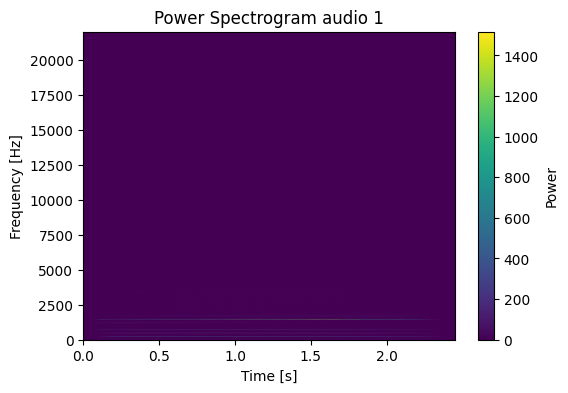

In [152]:
plt.figure(figsize=(6, 4))
plt.imshow(power_spectrum1, origin='lower', aspect='auto',
           extent=[0, nframes * hop_size1 / fs_audio1, 0, fs_audio1 / 2])
plt.title('Power Spectrogram audio 1')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Power')
plt.show()

#### Plot the logarithm of the matrix.

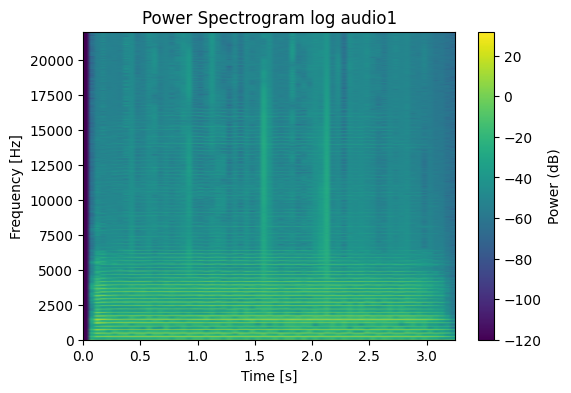

In [153]:
plot_spectrogram(power_spectrum1, fs_audio1, hop_size1, title_='Power Spectrogram log audio1')

#### What differences do you observe?

#### <font color='#A52A2A'>  My Observation:

When we look at the linear power spectrogram, only a few strong frequency components are clearly visible, while weaker components are almost invisible. However, in the logarithmic (dB) spectrogram, much more detail becomes visible across frequencies.

This happens because the linear scale represents power values directly, so large amplitudes dominate the display and mask softer components. The logarithmic scale compresses the dynamic range, reducing the difference between strong and weak signals. As a result, quieter harmonics, background noise, and subtle spectral features become easier to see.

### 2.  Analyse the effect of window size on the spectrum. (1 point)

#### a) Calculate spectrogram with librosa and nfft=window size

#### <font color='#A52A2A'> Process Explanation

First, we manually implement the spectrogram to understand the core concepts such as: **framing, windowing, overlap, FFT, and power spectrum.** After that, we use Librosa to compare our results with a professional and standardized implementation. <span style="color:blue"> **librosa_power_spectrogram** <span style="color:black">function created for that.

I leaned that Librosa is a Python library for audio and music analysis. It works like a powerful toolbox that makes working with sound signals fast, easy, and efficient. It can:
* Load audio files (WAV, MP3, FLAC, etc.)
* Compute spectrograms using STFT
* Extract audio features, same as:
    * MFCCs (used in speech and music recognition)
    * Pitch (fundamental frequency)
    * Tempo or beat tracking
    * Harmonic and percussive components
* Audio processing tools, such as:
    * Time-stretching and pitch-shifting
    * Filtering and noise reduction
    * Silence removal

**More:**

* Automatically normalizes audio to the range [-1, 1]
* Provides many ready-to-use functions like stft(), mfcc(), beat.tempo()
* Supports advanced music analysis such as chroma features, harmonic-percussive separation, and key detection

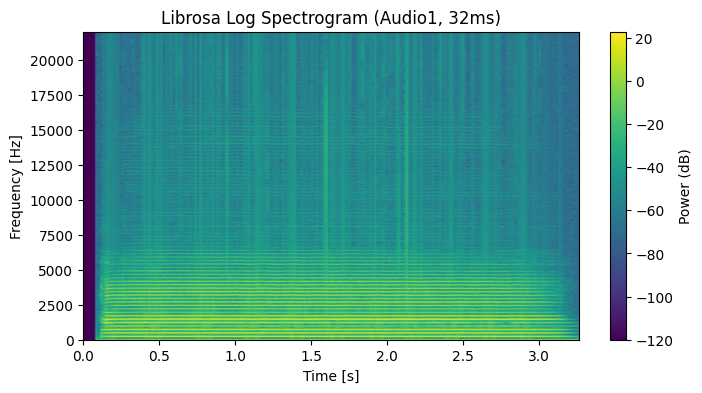

In [157]:
# Compute using librosa
P, X, t, f, fs = librosa_power_spectrogram(x_audio1, fs_audio1, win_ms=32)
# Plot
plot_librosa_spectrogram_db(P, t, f, title='Librosa Log Spectrogram (Audio1, 32ms)')

#### Are there any differences from your own implementation?

#### <font color='#A52A2A'>  My Observation:

There are only minor differences between my implementation of the spectrogram and the one computed using Librosa. These differences are very subtle and difficult to see, even when both spectrograms are plotted side by side. The most likely reasons for these variations are related to Librosa’s internal processing. I found the following reasons:

* Normalize the window function differently,
* Apply different scaling to the FFT output,
* Use zero-padding or center the frames by default (center=True),
* Introduce small numerical differences due to floating-point precision or internal smoothing.

Because of these small differences in normalization, window handling, and FFT alignment, the spectrograms are not visually identical. However, the overall time–frequency structure remains consistent between both methods.

			>-----------------------------------audio1-----------------------------------<


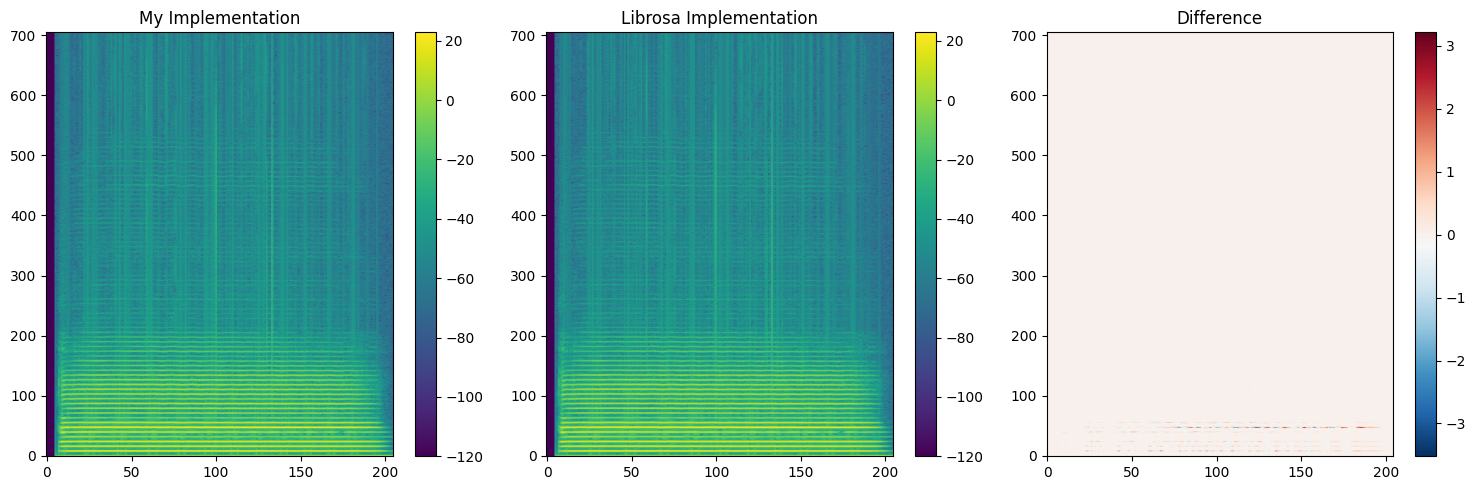

			>-----------------------------------audio2-----------------------------------<


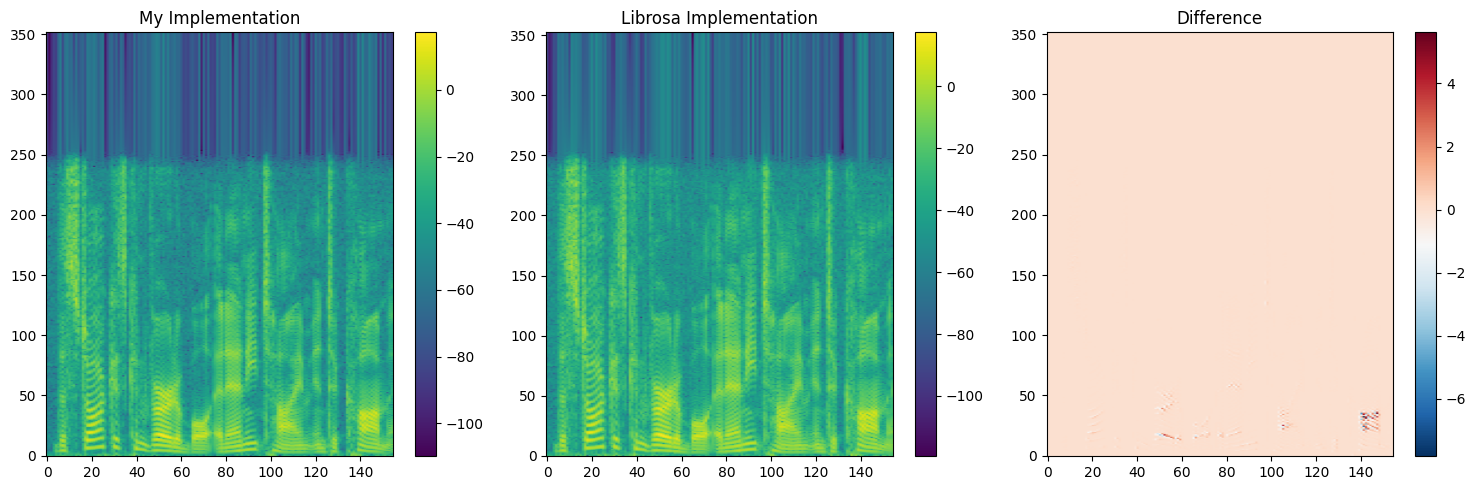

			>--------------------------------------X-------------------------------------<


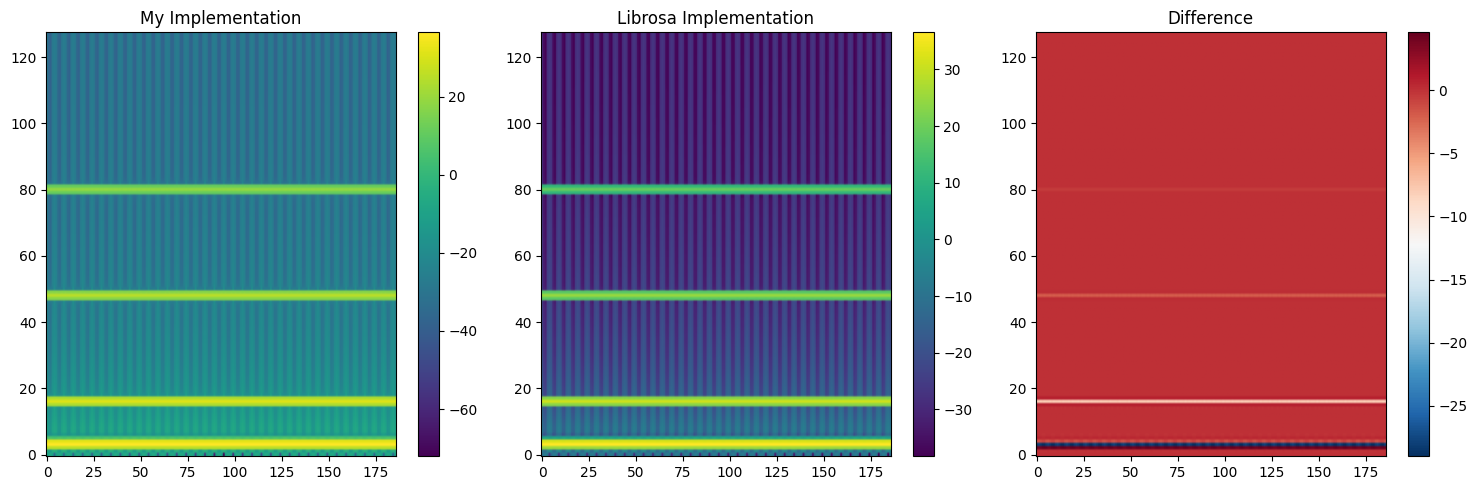

In [192]:
# Compare for each signal type
print("\t\t\t>-----------------------------------audio1-----------------------------------<")
compare_with_librosa(x_audio1, fs_audio1)
print("\t\t\t>-----------------------------------audio2-----------------------------------<")
compare_with_librosa(x_audio2, fs_audio2) 
print("\t\t\t>--------------------------------------X-------------------------------------<")
compare_with_librosa(x, sampling_rate)

#### b) Apply your implementation with different window sizes (16ms, 32ms, 64ms and 128ms) to different signals (audio1, audio2 and synthetic sinusoids from exercise 1)

#### Note. You can define your implementation from problem 1 as a function and call it for each of the signals.

=== Testing Music (Audio1) ===


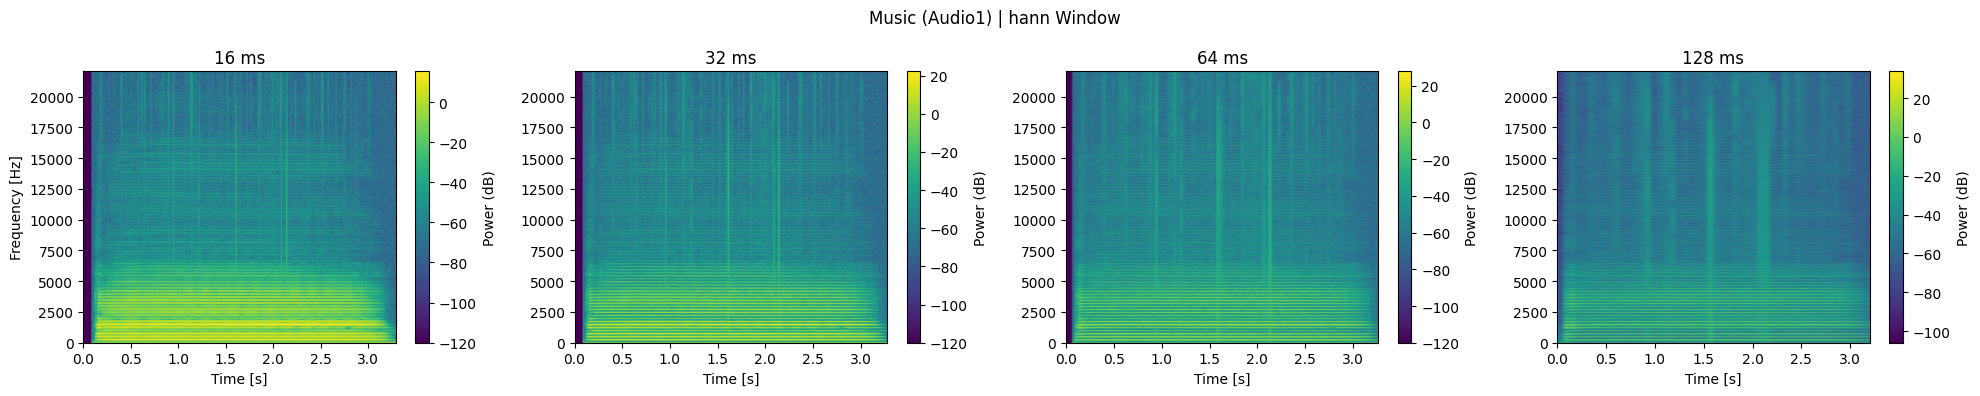

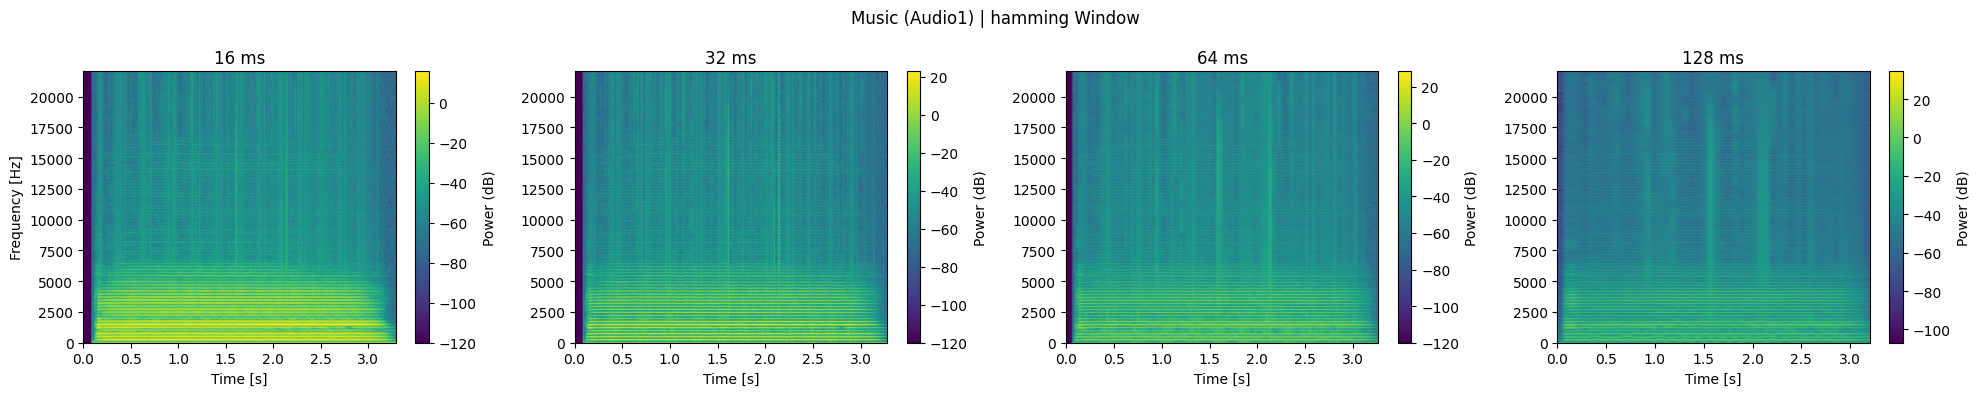

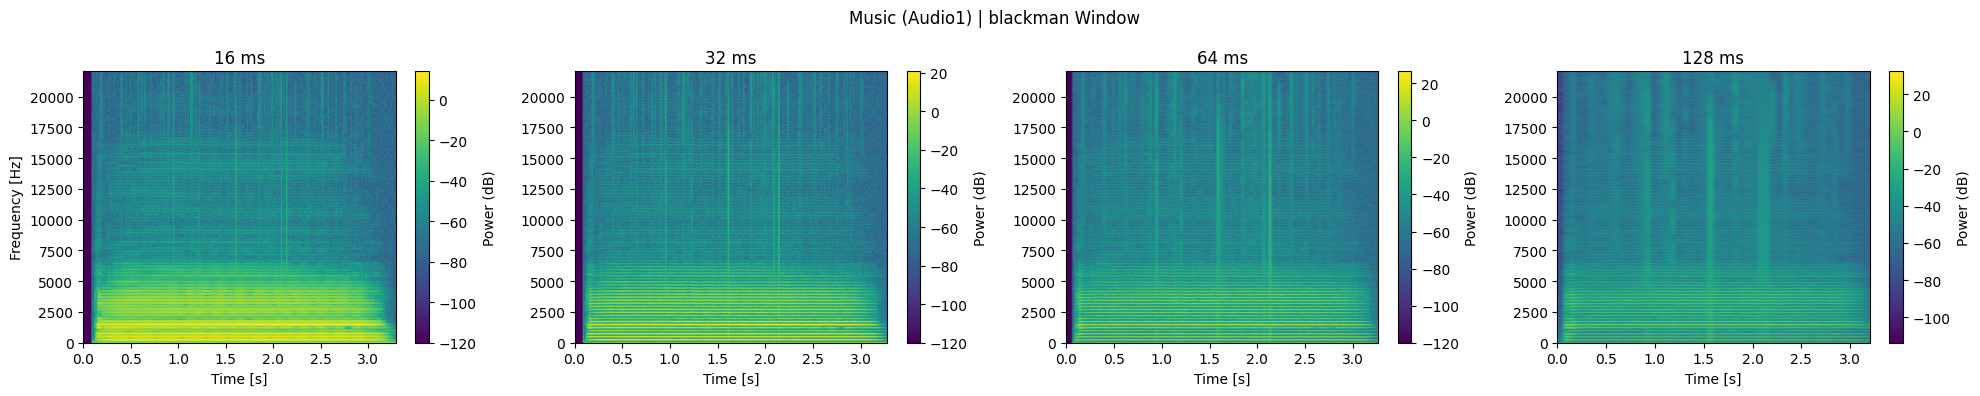

=== Testing Speech (Audio2) ===


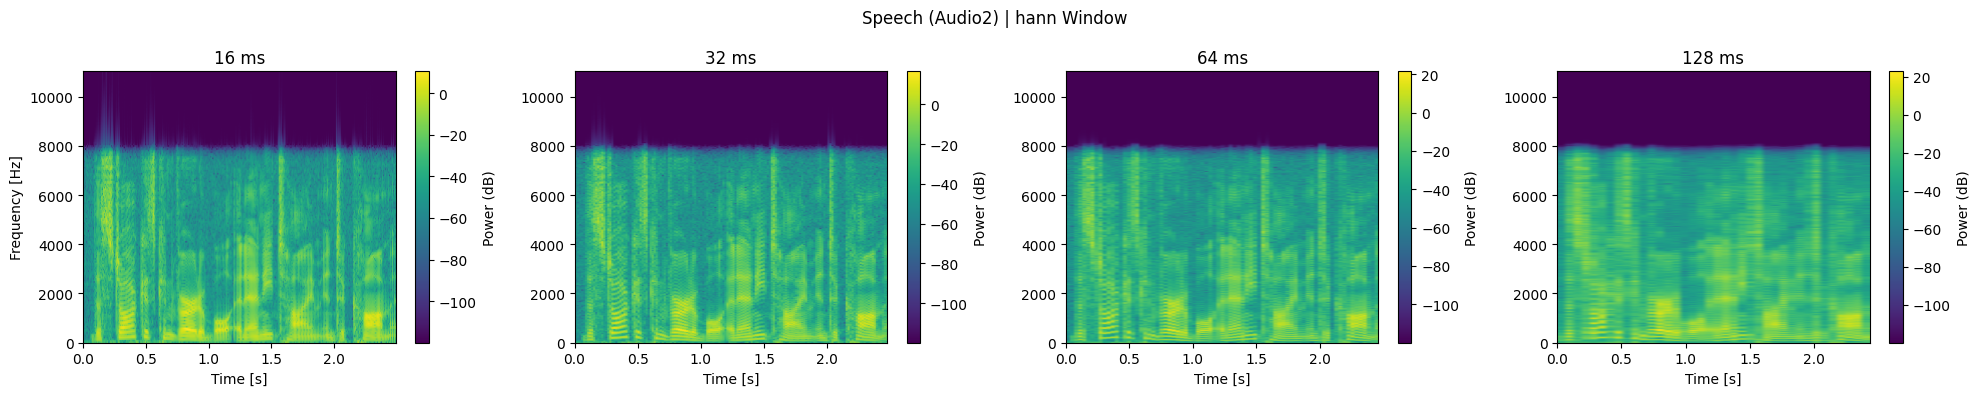

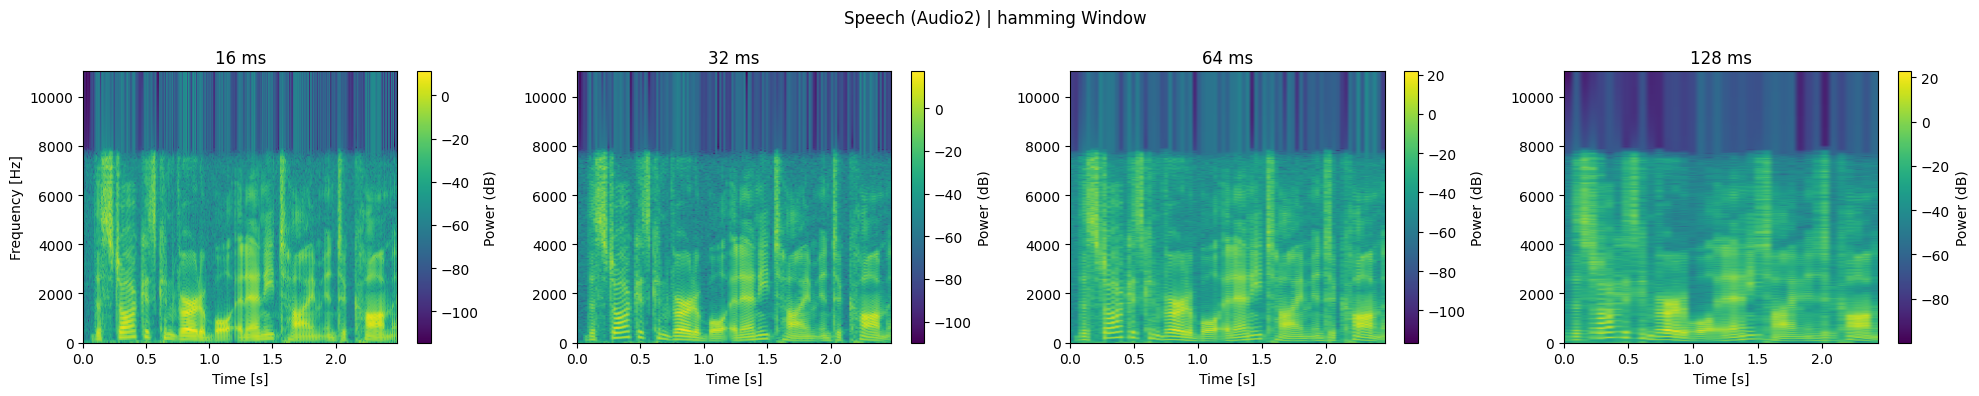

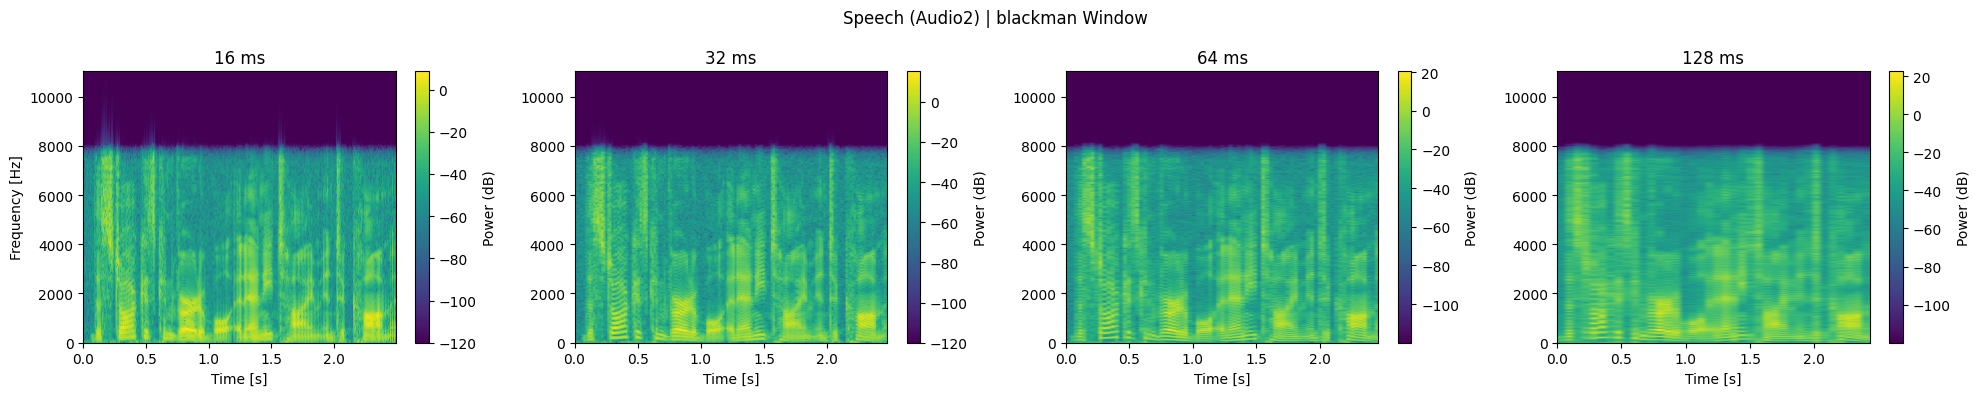

=== Testing Synthetic Sinusoids ===


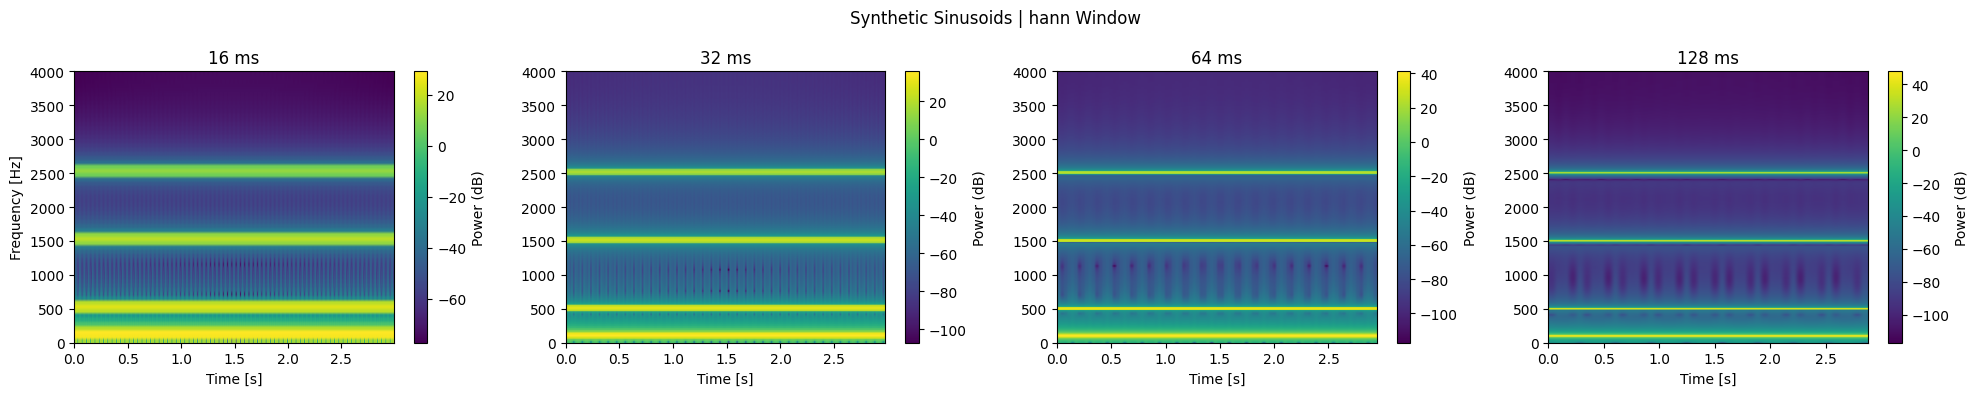

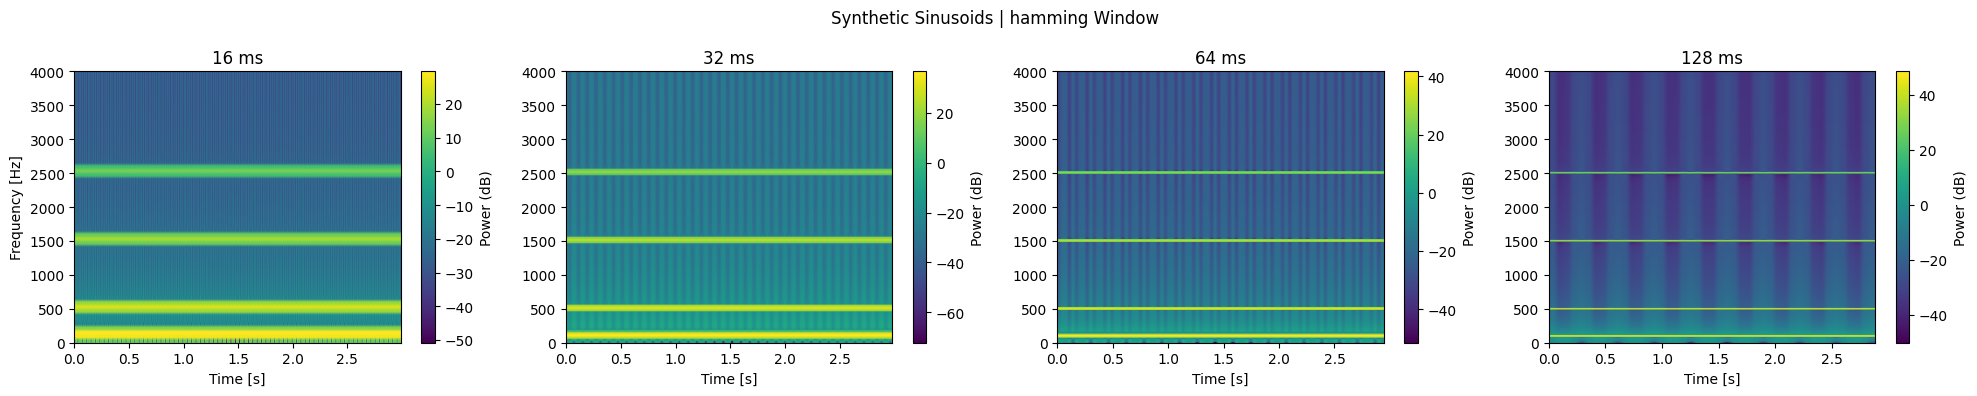

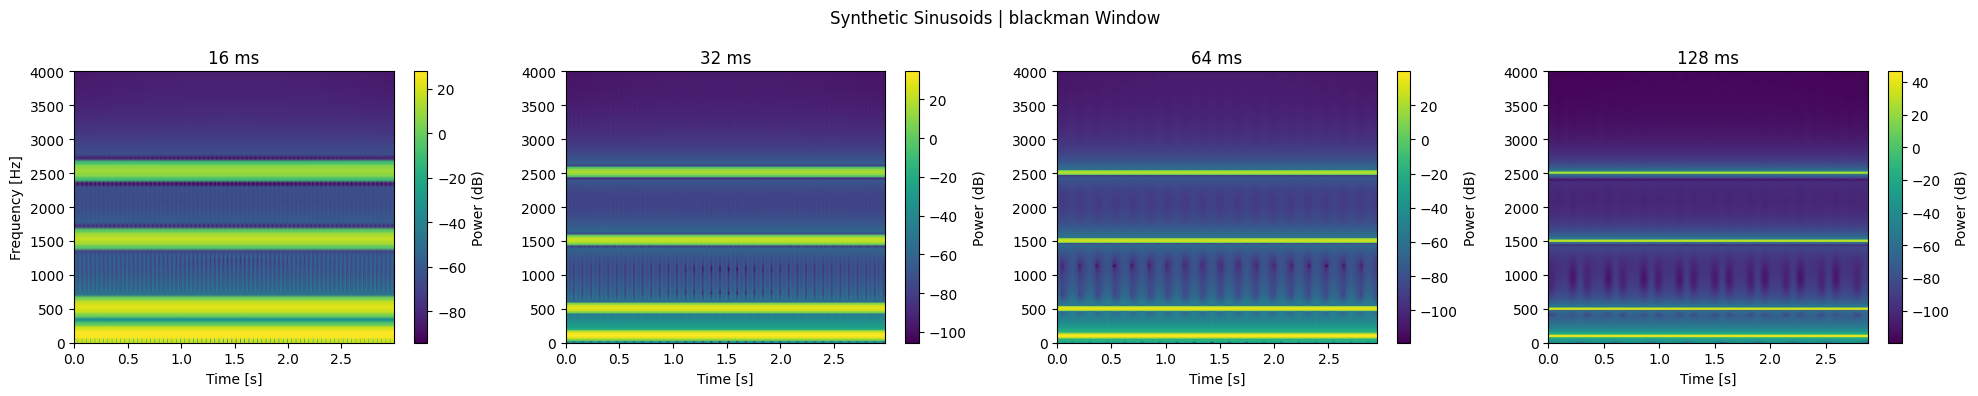

In [160]:
window_types = ['hann', 'hamming', 'blackman']
win_ms_list = [16, 32, 64, 128]  

print("=== Testing Music (Audio1) ===")
test_windows_on_audio(x_audio1, fs_audio1, 'Music (Audio1)', window_types, win_ms_list)

print("=== Testing Speech (Audio2) ===")
test_windows_on_audio(x_audio2, fs_audio2, 'Speech (Audio2)', window_types, win_ms_list)

print("=== Testing Synthetic Sinusoids ===")
test_windows_on_audio(x, sampling_rate, 'Synthetic Sinusoids', window_types, win_ms_list)

#### c) What happens when the window size is increased?

#### <font color='#A52A2A'> My Observation

For this part, I implemented the following changes: different window types, different window sizes, and used Audio1, Audio2, and the synthetic signal X as inputs. The differences between some configurations were obvious while others were more subtle. Let's examine them one by one:

<font color='blue'>**Audio1: Music**

##### Frequency Analysis (focusing on horizontal lines):

* The 128ms window appears blurry with poor frequency resolution
* The 16ms window is very bright but has limited frequency detail
* No significant visual difference between 32ms and 64ms windows, though both appear to offer better frequency resolution

##### Time Analysis (focusing on vertical lines):

* Shorter windows provide better time resolution
* 16ms performs better than 32ms for tracking temporal changes

##### Window Type Comparison:

* Hamming window provides clearer visualization than Hann
* Blackman window outperforms Hamming in terms of frequency clarity

<font color='blue'>**Audio2: Speech**

##### Window Size Effects:

* 16ms and 32ms windows perform best for speech analysis
* Larger windows appear less suitable for speech signals

##### Interesting Observation:

Contrary to expectations, Hamming window performed better than Blackman for speech

This finding prompted further research, which confirmed that the recommended window size for speech is typically 20-30ms, aligning with my experimental observations

**<font color='blue'> Why Hamming is Better for Speech?** 
1. Dynamic Nature of Speech: Speech has rapid temporal changes, for ex, in **"Hello"** we can see rapid changes:
"h" → "e" → "l" → "o"
    * Start and end of syllables
    * Transitions between consonants and vowels
    * Formant transitions
3. Need for Better Time Resolution:
    * **Hamming: Narrower main lobe → Better time resolution**
    * **Blackman: Wider main lobe → Poorer time resolution**
4. Speech Formants: Speech formants (F1, F2, F3) typically:
    * Low frequencies: 200-1000 Hz
    * Relatively wide bandwidth: Don't require extremely high frequency precision

**<font color='blue'>What I see in my spectrogram:**
    
**With Hamming:**

    Formants: |███|    |██|     |█|       ← Clear and distinct

    Time:.........↑.........↑......↑........ ← Clear temporal changes
**With Blackman:**

    Formants: |████|    |███|     |██|        ← Wide and slightly blurred

    Time:........↑...........↑..........↑........← Less clear temporal changes
**As speech needs good time resolution so Hamming is more suitable.
Stable music needs excellent frequency resolution so Blackman is more suitable.**

#### What analysis window lenght is best for each of the signal types?

#### <font color='#A52A2A'> My Observation

Recommended for **music** analysis: **32-64 ms**

* Balances temporal transients (drums, attacks) with harmonic resolution
* Shorter windows preserve rhythmic details, longer windows resolve harmonics

Recommended for **speech** analysis: **20-30 ms**

* Matches typical phoneme duration and formant transitions
* Preserves rapid speech events while maintaining formant clarity

**Key Insight:** Music benefits from longer analysis windows to capture harmonic structure, while speech requires shorter windows to track rapid articulatory changes.

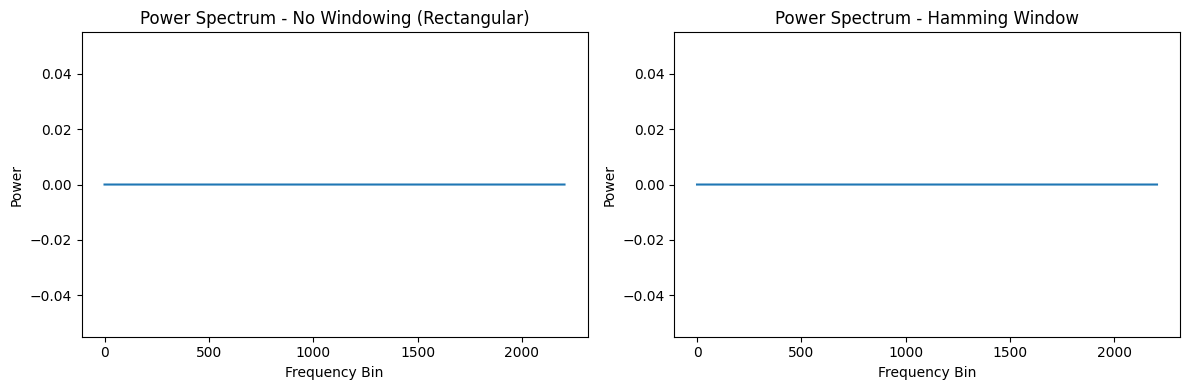

(array([0., 0., 0., ..., 0., 0., 0.], shape=(2205,)),
 array([0., 0., 0., ..., 0., 0., 0.], shape=(2205,)))

In [185]:
compare_windowing(x_audio1, fs_audio1, win_size_test, nfft_test, start_index=0)

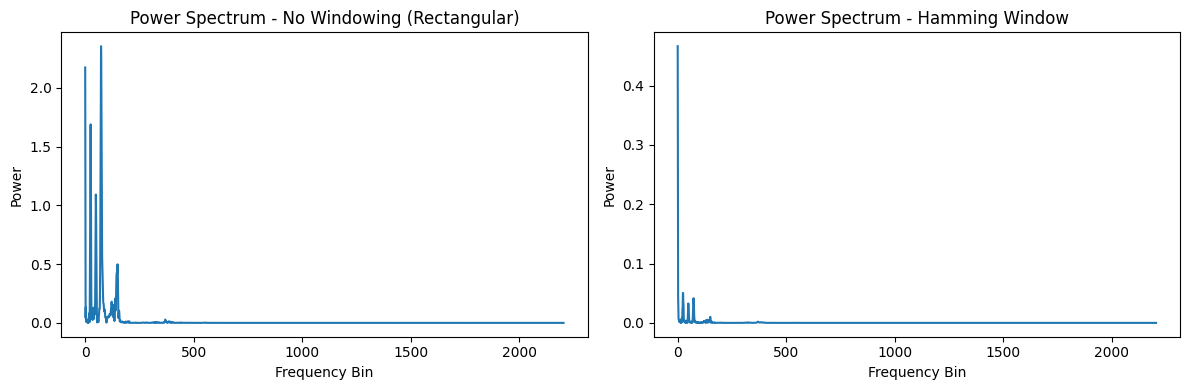

(array([2.17366286e+00, 7.73772017e-01, 4.30263798e-02, ...,
        2.36667138e-06, 2.21877048e-06, 2.17977822e-06], shape=(2205,)),
 array([4.66345336e-01, 2.43811941e-01, 4.40700218e-02, ...,
        4.70629003e-08, 1.61845822e-08, 3.27336396e-08], shape=(2205,)))

In [182]:

# Test the comparison
win_size_test = int(0.1 * fs_audio1)  # 100ms window
nfft_test = win_size_test
compare_windowing(x_audio1, fs_audio1, win_size_test, nfft_test)

#### <font color='#A52A2A'> My Observation

In the first frame, they were completely similar, so I focused on the second frame.

When no window is used, the spectrum has sharp peaks but lots of noise and leakage.
When a Hamming window is applied, the spectrum becomes smoother and cleaner with less leakage.

In [186]:
#compare_windowing(x_audio1, fs_audio1, win_size_test, nfft_test, start_index=2 * hop_size)

### Bonus problem: Implement overlap-add reconstruction

Testing Overlap-Add Reconstruction on Synthetic Signal...


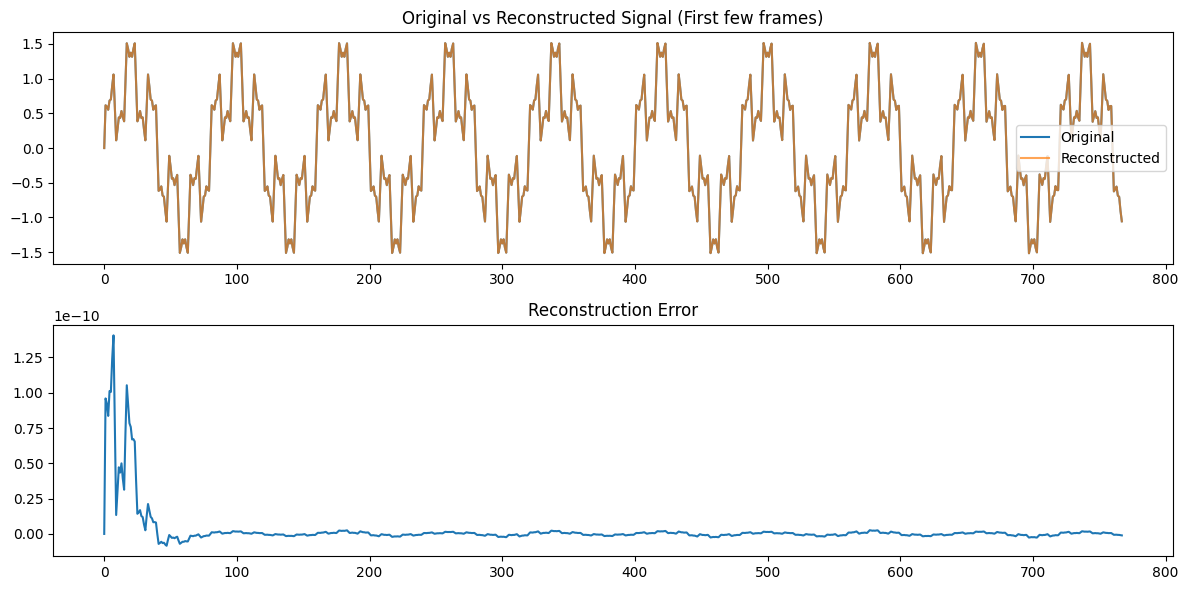

Reconstruction MSE: 1.95e-03


In [134]:
def overlap_add_analysis(x_original, fs, win_ms=32, hop_ratio=0.5):
    """Implement overlap-add reconstruction (Bonus problem)"""
    
    win_size = int(win_ms * 1e-3 * fs)
    hop_size = int(hop_ratio * win_size)
    nfft = win_size
    
    # Use symmetric window (Hamming is symmetric)
    window = hamming(win_size)
    
    # Analysis: break into frames (as before)
    n_frames = int((len(x_original) - win_size) / hop_size) + 1
    
    # Store complex spectra for reconstruction
    complex_spectra = []
    
    for i in range(n_frames):
        start = i * hop_size
        frame = x_original[start:start + win_size]
        frame_windowed = frame * window
        spectrum = fft(frame_windowed, nfft)
        complex_spectra.append(spectrum)
    
    # Synthesis: overlap-add reconstruction
    reconstructed = np.zeros(len(x_original))
    window_sum = np.zeros(len(x_original))
    
    for i in range(n_frames):
        start = i * hop_size
        # Inverse FFT
        frame_reconstructed = np.real(ifft(complex_spectra[i]))
        # Apply window again for perfect reconstruction
        frame_reconstructed *= window
        # Overlap-add
        reconstructed[start:start + win_size] += frame_reconstructed
        window_sum[start:start + win_size] += window ** 2
    
    # Normalize by window sum to compensate for overlap
    reconstructed = reconstructed / (window_sum + 1e-12)
    
    # Compare original and reconstructed
    plt.figure(figsize=(12, 6))
    
    # Plot first few frames to see discontinuities
    compare_samples = min(win_size * 3, len(x_original))
    
    plt.subplot(2, 1, 1)
    plt.plot(x_original[:compare_samples], label='Original')
    plt.plot(reconstructed[:compare_samples], label='Reconstructed', alpha=0.7)
    plt.title('Original vs Reconstructed Signal (First few frames)')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(x_original[:compare_samples] - reconstructed[:compare_samples])
    plt.title('Reconstruction Error')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate reconstruction error
    mse = np.mean((x_original[:len(reconstructed)] - reconstructed) ** 2)
    print(f"Reconstruction MSE: {mse:.2e}")
    
    return reconstructed, mse

# Test overlap-add on synthetic signal
print("Testing Overlap-Add Reconstruction on Synthetic Signal...")
reconstructed, error = overlap_add_analysis(x, sampling_rate)